<a href="https://colab.research.google.com/github/monta0315/yolo_vs_detr/blob/main/DETR_compare1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5とDETRで同じ画像を投げてどういうリターンがくるのかを試すサンプル

## DETR版

### Reference

https://www.ogis-ri.co.jp/otc/hiroba/technical/detr/part1.html

https://github.com/ultralytics/yolov5


In [ ]:
import torch, torchvision
import torchvision.transforms as T
from torch import nn
from torchvision.models import resnet50
import requests
import matplotlib.pyplot as plt
from PIL import Image

print(torch.__version__)         # 1.9.0+cu102
print(torchvision.__version__)   # 0.10.0+cu102

1.9.0+cu111
0.10.0+cu111


## 使用モデルはDETR-R50 => 最もシンプルなモデルだそうです

In [ ]:
# DETR_R101の場合は'detr_resnet101'、DETR-DC5_R50の場合は'detr_resnet50_dc5'のように指定
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50_dc5', pretrained=True)
#model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


# 推論処理

In [ ]:
url = 'https://rimage.gnst.jp/livejapan.com/public/article/detail/a/00/04/a0004228/img/basic/a0004228_main.jpg?20200818132235&q=80&rw=750&rh=536'
im = Image.open(requests.get(url, stream=True).raw)

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = transform(im).unsqueeze(0)
outputs = model(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


# 推論結果の可視化のための準備

In [ ]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

### 座標変換関数とバウンディングボックスのリスケール関数を定義

=> outputs['pred_boxes']に座標が格納されていますが、(center_x, center_y, width, height) の形で保持されています。そのままでは表示する際に使いにくいので、(xmin, ymin, xmax, ymax) の形に座標変換します。

In [ ]:
def box_cxcywh_to_xyxy(x):
    """
    (center_x, center_y, width, height)から(xmin, ymin, xmax, ymax)に座標変換
    """
    # unbind(1)でTensor次元を削除
    # (center_x, center_y, width, height)*N → (center_x*N, center_y*N, width*N, height*N)
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    # (center_x, center_y, width, height)*N の形に戻す
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    """
    バウンディングボックスのリスケール
    """
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    # バウンディングボックスの[0～1]から元画像の大きさにリスケール
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


### 画像の表示とバウンディングボックスの表示関数を定義

In [ ]:
def plot_results(pil_img, prob, boxes):
    """
    画像とバウンディングボックスの表示
    """
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            # バウンディングボックスの表示
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                         fill=False, color=c, linewidth=3))
            # 最大の予測値を持っているクラスのindexを取得
            cl = p.argmax()
            # クラス名と予測値の表示
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# 推論実行

### threshouldで画像内に表示する閾値を決めている

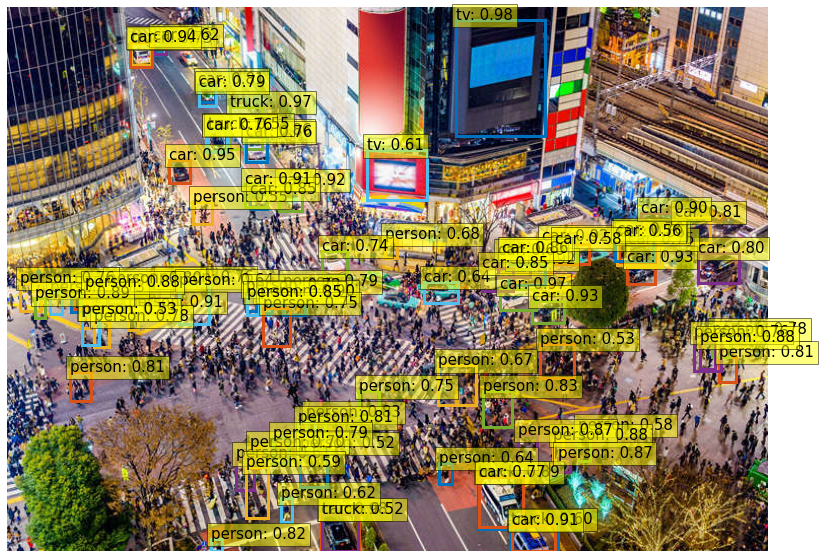

In [ ]:
threshold = 0.5
# no-objectを除いた91クラスでsoftmax
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
# 91クラスの中で一番大きい予測値を取得*N個して、閾値を超えればTrue、それ以下だとFalse
keep = probas.max(-1).values > threshold
# バウンディングボックスの前処理
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
# 画像とバウンディングボックスの表示
plot_results(im, probas[keep], bboxes_scaled)